In [1]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from sklearn import utils
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf
tf.random.set_seed(777)

In [2]:
import joblib

In [3]:
##########데이터 로드

df = pd.read_csv('https://raw.githubusercontent.com/kairess/stock_crypto_price_prediction/master/dataset/eth.csv')

In [4]:
df.head()

Date    Open    High     Low   Close          Volume  \
0  31.Oct.17  307.38  310.55  305.88  305.88  369,583,008.00   
1   1.Nov.17  305.76  306.40  290.58  291.69  553,864,000.00   
2   2.Nov.17  290.73  293.91  281.17  287.43  904,900,992.00   
3   3.Nov.17  288.50  308.31  287.69  305.71  646,339,968.00   
4   4.Nov.17  305.48  305.48  295.80  300.47  416,479,008.00   

          Market Cap  
0  29,331,517,440.00  
1  29,183,592,448.00  
2  27,754,237,952.00  
3  27,547,410,432.00  
4  29,175,347,200.00

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        365 non-null    object 
 1   Open        365 non-null    float64
 2   High        365 non-null    float64
 3   Low         365 non-null    float64
 4   Close       365 non-null    float64
 5   Volume      365 non-null    object 
 6   Market Cap  365 non-null    object 
dtypes: float64(4), object(3)
memory usage: 20.1+ KB


### 단일 특성 시계열 분석

In [7]:
## 필요변 추출
df = df[['Close']]
df.head()

Close
0  305.88
1  291.69
2  287.43
3  305.71
4  300.47

In [8]:
# train/test 데이터 분리
data = df.values
train = data[:(len(data) - int(len(data)*0.3))]
test = data[:int(len(data)*0.3)]

In [9]:
train

array([[ 305.88],
       [ 291.69],
       [ 287.43],
       [ 305.71],
       [ 300.47],
       [ 296.26],
       [ 298.89],
       [ 294.66],
       [ 309.07],
       [ 320.88],
       [ 299.25],
       [ 314.68],
       [ 307.91],
       [ 316.72],
       [ 337.63],
       [ 333.36],
       [ 330.92],
       [ 332.39],
       [ 347.61],
       [ 354.39],
       [ 366.73],
       [ 360.4 ],
       [ 380.65],
       [ 410.17],
       [ 474.91],
       [ 466.28],
       [ 471.33],
       [ 480.36],
       [ 472.9 ],
       [ 427.52],
       [ 447.11],
       [ 466.54],
       [ 463.45],
       [ 465.85],
       [ 470.2 ],
       [ 463.28],
       [ 428.59],
       [ 434.41],
       [ 456.03],
       [ 473.5 ],
       [ 441.72],
       [ 515.14],
       [ 651.43],
       [ 702.77],
       [ 695.82],
       [ 684.45],
       [ 696.21],
       [ 719.97],
       [ 794.65],
       [ 826.82],
       [ 819.09],
       [ 821.06],
       [ 674.86],
       [ 719.39],
       [ 694.15],
       [ 7

In [10]:
## 데이터 범위 한정 : MinMaxScaler()
transformer = MinMaxScaler()
train = transformer.fit_transform(train) # train데이터로 모델 핏팅했으면
test = transformer.transform(test) # 학습데이터에는 변환만 진행해야 하고
# 새로운 값으로 예측을 진행 할 때도 변환만 진행해야 하므로 transformer객체는 저장해야 함

In [12]:
## MinMaxScaler()객체 저장
joblib.dump(transformer, 'model/ethereum_price_regression_model_transformer.pkl')

['model/ethereum_price_regression_model_transformer.pkl']

In [13]:
## 7일치 데이터를 보고 다음날 예측
sequence_length = 7 #1주일치 데이터를 보고 다음날을 예측
window_length = sequence_length + 1
x_train = []
y_train = []
for i in range(0, len(train) - window_length + 1):
    window = train[i:i + window_length, :]
    x_train.append(window[:-1])
    y_train.append(window[-1])

In [26]:
x_test = []
y_test = []
for i in range(0, len(test) - window_length + 1):
    window = test[i:i + window_length, :]
    x_test.append(window[:-1])
    y_test.append(window[-1])
x_test = np.array(x_test)
y_test = np.array(y_test)

In [18]:
x_train = np.array(x_train)
y_train = np.array(y_train)


In [22]:
x_train[0]

array([[0.01663676],
       [0.00384133],
       [0.        ],
       [0.01648347],
       [0.01175845],
       [0.0079622 ],
       [0.01033373]])

In [19]:
print(x_train.shape)
x_train[0].shape

(249, 7, 1)


(7, 1)

In [21]:
pd.DataFrame((x_train.reshape(249,7)))

0         1         2         3         4         5         6
0    0.016637  0.003841  0.000000  0.016483  0.011758  0.007962  0.010334
1    0.003841  0.000000  0.016483  0.011758  0.007962  0.010334  0.006519
2    0.000000  0.016483  0.011758  0.007962  0.010334  0.006519  0.019513
3    0.016483  0.011758  0.007962  0.010334  0.006519  0.019513  0.030163
4    0.011758  0.007962  0.010334  0.006519  0.019513  0.030163  0.010658
..        ...       ...       ...       ...       ...       ...       ...
244  0.169451  0.159397  0.162211  0.168604  0.168243  0.184159  0.181868
245  0.159397  0.162211  0.168604  0.168243  0.184159  0.181868  0.170651
246  0.162211  0.168604  0.168243  0.184159  0.181868  0.170651  0.132544
247  0.168604  0.168243  0.184159  0.181868  0.170651  0.132544  0.143455
248  0.168243  0.184159  0.181868  0.170651  0.132544  0.143455  0.128622

[249 rows x 7 columns]

In [ ]:
## 모델 생성(딥러닝 LSTM은 3차원 데이터 형식을 사용한다)

In [24]:
input = Input(shape=(sequence_length, 1))
net = LSTM(units=10)(input)
net = Dense(units=1)(net)
model = Model(inputs=input, outputs=net)

model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 7, 1)]            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 10)                480       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________


In [27]:
model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.01))

model.fit(x_train, y_train, epochs=60, validation_data=(x_test, y_test), callbacks=[ModelCheckpoint(filepath='model/ethereum_price_regression_model.h5', save_best_only=True, verbose=1)]) 

Epoch 1/60
8/8 [==============================] - 4s 161ms/step - loss: 0.1125 - val_loss: 0.0362

Epoch 00001: val_loss improved from inf to 0.03623, saving model to model\ethereum_price_regression_model.h5
Epoch 2/60
8/8 [==============================] - 0s 16ms/step - loss: 0.0344 - val_loss: 0.0260

Epoch 00002: val_loss improved from 0.03623 to 0.02601, saving model to model\ethereum_price_regression_model.h5
Epoch 3/60
8/8 [==============================] - 0s 15ms/step - loss: 0.0144 - val_loss: 0.0234

Epoch 00003: val_loss improved from 0.02601 to 0.02338, saving model to model\ethereum_price_regression_model.h5
Epoch 4/60
8/8 [==============================] - 0s 14ms/step - loss: 0.0074 - val_loss: 0.0084

Epoch 00004: val_loss improved from 0.02338 to 0.00845, saving model to model\ethereum_price_regression_model.h5
Epoch 5/60
8/8 [==============================] - 0s 15ms/step - loss: 0.0068 - val_loss: 0.0082

Epoch 00005: val_loss improved from 0.00845 to 0.00823, savin

8/8 [==============================] - 0s 15ms/step - loss: 0.0025 - val_loss: 0.0042

Epoch 00045: val_loss did not improve from 0.00403
Epoch 46/60
8/8 [==============================] - 0s 15ms/step - loss: 0.0023 - val_loss: 0.0040

Epoch 00046: val_loss improved from 0.00403 to 0.00402, saving model to model\ethereum_price_regression_model.h5
Epoch 47/60
8/8 [==============================] - 0s 15ms/step - loss: 0.0024 - val_loss: 0.0039

Epoch 00047: val_loss improved from 0.00402 to 0.00391, saving model to model\ethereum_price_regression_model.h5
Epoch 48/60
8/8 [==============================] - 0s 15ms/step - loss: 0.0024 - val_loss: 0.0038

Epoch 00048: val_loss improved from 0.00391 to 0.00376, saving model to model\ethereum_price_regression_model.h5
Epoch 49/60
8/8 [==============================] - 0s 15ms/step - loss: 0.0017 - val_loss: 0.0045

Epoch 00049: val_loss did not improve from 0.00376
Epoch 50/60
8/8 [==============================] - 0s 16ms/step - loss: 0.00

In [28]:
y_predict = model.predict(x_test)

In [29]:
y_predict

array([[0.01692354],
       [0.01549158],
       [0.02031184],
       [0.02805808],
       [0.02394076],
       [0.02752595],
       [0.02643535],
       [0.0293575 ],
       [0.03971688],
       [0.04419448],
       [0.04571136],
       [0.04628633],
       [0.05291123],
       [0.05928434],
       [0.06823564],
       [0.07050776],
       [0.08022681],
       [0.09844592],
       [0.13862751],
       [0.15595801],
       [0.16636738],
       [0.17407514],
       [0.1719917 ],
       [0.14728053],
       [0.14368404],
       [0.15210135],
       [0.15559614],
       [0.1592673 ],
       [0.16354847],
       [0.16209638],
       [0.1432477 ],
       [0.13641435],
       [0.14364783],
       [0.15661727],
       [0.14847355],
       [0.18083796],
       [0.2683643 ],
       [0.33996192],
       [0.3677233 ],
       [0.36914268],
       [0.37110227],
       [0.3801164 ],
       [0.4260539 ],
       [0.4649738 ],
       [0.4754764 ],
       [0.47822344],
       [0.38732186],
       [0.377

In [30]:
y_predict_inverse = []
for y in y_predict:
    inverse = transformer.inverse_transform([[0, 0, 0, 0, 0, 0, y[0]]])
    y_inverse = inverse.flatten()[-1]
    print(y_inverse)
    y_predict_inverse.append(y_inverse)

306.19804002452645
304.61001209048555
309.95562937257813
318.5461342734658
313.98006001338365
317.95600766934456
316.74653783898805
319.98717434011405
331.47562773481013
336.4412388891727
338.1234420932085
338.76107669308783
346.1080243273825
353.1757450024784
363.1026459612698
365.62239784099165
376.4007286760211
396.60554318994286
441.16652702048424
460.38587544664745
471.92976275473836
480.477591226548
478.1670819199086
450.76263401255017
446.7741684882343
456.1088792537153
459.98456002354624
464.0558500444889
468.80361723899847
467.193265773058
446.2902599218488
438.7121489852667
446.7340121580661
461.11698505952955
452.085677677542
487.9774882081151
585.0433364403248
664.4443654558062
695.23144710958
696.8055422016978
698.9787102490664
708.9752898770571
759.9195272561907
803.0813025963306
814.7285883232951
817.7750160872936
716.9660690757632
705.974075166285
683.3967651751638
725.1904159989953
750.6382591128349
756.0075074863433
741.5797511878609
742.8676621952652
718.703400476276

In [31]:
y_test_inverse = []
for y in y_test:
    inverse = transformer.inverse_transform([[0, 0, 0, 0, 0, 0, y[0]]])
    y_inverse = inverse.flatten()[-1]
    print(y_inverse)
    y_test_inverse.append(y_inverse)

294.66
309.07
320.88
299.25
314.67999999999995
307.91
316.72
337.63000000000005
333.36
330.92
332.39
347.61
354.39
366.73
360.4
380.65
410.17
474.91
466.28
471.33
480.36
472.9
427.52
447.11
466.54
463.45
465.85
470.2
463.28
428.59000000000003
434.40999999999997
456.03
473.5
441.72
515.14
651.43
702.77
695.82
684.45
696.21
719.97
794.65
826.82
819.09
821.06
674.86
719.39
694.15
765.83
773.84
762.84
737.02
753.59
717.26
756.73
772.64
884.4399999999999
962.7199999999999
980.9199999999998
997.7199999999998
1041.68
1153.17
1148.53
1299.74
1255.82
1154.93
1273.2
1396.4199999999998
1366.77
1291.92
1053.6899999999998
1014.25
1036.28
1039.1
1155.15
1049.58
1003.26
986.23
1058.7799999999997
1056.03
1055.17
1107.0699999999997
1246.01
1182.36
1071.1299999999999
1118.31
1036.79
915.78
964.0200000000001
834.6800000000001
697.95
793.12
757.07
817.81
883.8599999999998
860.41
814.66
868.7099999999998
845.26
923.5599999999997
936.9799999999999
944.21


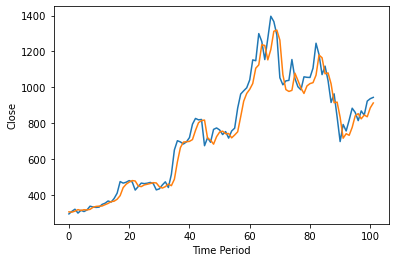

In [32]:
import matplotlib.pyplot as plt
plt.plot(y_test_inverse)
plt.plot(y_predict_inverse)
plt.xlabel('Time Period')
plt.ylabel('Close')
plt.show()

### 새로운 데이터를 이용해서 시세 예측
- [305.88, 291.69, 287.43, 305.71, 300.47, 296.26, 298.89]

In [33]:
org = np.array([[305.88, 291.69, 287.43, 305.71, 300.47, 296.26, 298.89]]).reshape(-1,1)

In [34]:
# 1. 모델에 맞는 데이터 형태로 변환
org

array([[305.88],
       [291.69],
       [287.43],
       [305.71],
       [300.47],
       [296.26],
       [298.89]])

In [35]:
# 2. min_max_scaler 변환
x_test = transformer.transform(org)
x_test = x_test.reshape((1, 7, 1))
print(x_test)

[[[0.01663676]
  [0.00384133]
  [0.        ]
  [0.01648347]
  [0.01175845]
  [0.0079622 ]
  [0.01033373]]]


In [40]:
# 3. 모델 이용해서 예측
y_predict = model.predict(x_test)
# 4. 역변환
inverse = transformer.inverse_transform([[0, 0, 0, 0, 0, 0, y_predict.flatten()[0]]])
print(inverse.flatten()[-1])

306.19804002452645


In [41]:
from tensorflow.keras.models import load_model
import numpy as np

transformer = joblib.load('model/ethereum_price_regression_model_transformer.pkl') 

model = load_model('model/ethereum_price_regression_model.h5')

In [42]:
##########모델 예측

x_test = transformer.transform(org)
x_test = x_test.reshape((1, 7, 1))
print(x_test)

[[[0.01663676]
  [0.00384133]
  [0.        ]
  [0.01648347]
  [0.01175845]
  [0.0079622 ]
  [0.01033373]]]


In [43]:
y_predict = model.predict(x_test)
print(y_predict) 
print(y_predict.flatten()[0]) 

inverse = transformer.inverse_transform([[0, 0, 0, 0, 0, 0, y_predict.flatten()[0]]])
print(inverse.flatten()[-1])

[[0.03490014]]
0.034900136
326.13390214644375
